# Dataset file generation

In [ ]:
# Dataset file geneartion
import random
import numpy as np
import pandas as pd
from datasets import Dataset

# ==============================================================================
# SCRIPT TO GENERATE A COMPLETE, HIGH-QUALITY SYNTHETIC DATASET
# ==============================================================================
# This version includes scenarios for both incorrect and correct student answers.

print("Generating a complete Socratic fine-tuning dataset with enrichment examples...")

# --- 1. Define Building Blocks ---
STUDENT_STATES = ["CONCENTRATING", "BORED", "GAMING"]
PROBLEM_TEMPLATES = [
    {"skill": "addition", "template": "What is {a} + {b}?", "solution": lambda a,b: a+b},
    {"skill": "subtraction", "template": "What is {a} - {b}?", "solution": lambda a,b: a-b},
    {"skill": "multiplication", "template": "What is {a} * {b}?", "solution": lambda a,b: a*b},
    {"skill": "division", "template": "What is {a} / {b}?", "solution": lambda a,b: round(a/b, 2)},
    {"skill": "exponents", "template": "What is {a} to the power of {b}?", "solution": lambda a,b: a**b},
    {"skill": "percent-of", "template": "What is {a}% of {b}?", "solution": lambda a,b: (a/100)*b},
    {"skill": "equation", "template": "What is the value of x in the equation {a}x + {b} = {c}?", "solution": lambda a,b,c: (c-b)/a},
]

# GUIDING templates for when the student is WRONG
GUIDING_TEMPLATES = {
    "CONCENTRATING": "That's a good first try, but not quite. Can you walk me through the formula you used?",
    "BORED": "Not quite, but we can figure this out. Let's start with the basics. What does the key term in the problem mean?",
    "GAMING": "It seems like we might be guessing. Let's pause for a moment. What is the question actually asking for?",
}

# ENRICHMENT templates for when the student is CORRECT and CONCENTRATING
ENRICHMENT_TEMPLATES = [
    "Excellent! You solved that perfectly. For a challenge, can you think of a different way to solve the same problem?",
    "Great job! You've mastered this. Can you explain why your method works?",
    "Correct! You're showing great focus. Can you create a similar problem yourself?",
    "Perfect! Can you think of a real-world situation where you might use this skill?"
]


# --- 2. Define the Prompt Formatting Functions ---
def format_failure_prompt(sample):
    """Creates the structured chat prompt for an incorrect answer."""
    return f"<|user|>\nMy student's dominant state is {sample['state']}.\nProblem: '{sample['question']}'\nIncorrect Answer: {sample['wrong_answer']:.2f}\nGuide me Socratically.<|assistant|>"

def format_success_prompt(sample):
    """Creates the structured chat prompt for a correct answer."""
    return f"<|user|>\nMy student's dominant state is CONCENTRATING and they answered correctly.\nProblem: '{sample['question']}'\nCorrect Answer: {sample['solution']:.2f}\nEngage them with an enrichment question.<|assistant|>"


# --- 3. Generation Logic ---
def generate_socratic_sample():
    # Decide whether to generate a success or failure scenario
    scenario = random.choice(['success', 'failure', 'failure']) # 66% chance of failure scenario for more guidance examples

    problem_data = random.choice(PROBLEM_TEMPLATES)

    # Generate problem details
    if problem_data['skill'] == 'equation':
        a, b, c = random.randint(2, 5), random.randint(1, 10), random.randint(11, 20)
        question = problem_data["template"].format(a=a, b=b, c=c)
        solution = problem_data["solution"](a,b,c)
    else:
        a, b = random.randint(1, 20), random.randint(1, 10)
        question = problem_data["template"].format(a=a, b=b)
        solution = problem_data["solution"](a, b)

    if scenario == 'failure':
        state = random.choice(STUDENT_STATES)
        wrong_answer = solution + random.uniform(1, 5) * random.choice([-1, 1])

        prompt = format_failure_prompt({
            "state": state, "question": question, "wrong_answer": wrong_answer
        })
        chosen = GUIDING_TEMPLATES[state]
        rejected = f"Wrong. The correct answer is {solution:.2f}."

    else: # Success scenario
        prompt = format_success_prompt({
            "question": question, "solution": solution
        })
        chosen = random.choice(ENRICHMENT_TEMPLATES)
        rejected = "Correct. Good job." # A simple, non-Socratic rejection

    return {"prompt": prompt, "chosen": chosen, "rejected": rejected}


# --- 4. Generate and Save the Dataset ---
random.seed(42)
np.random.seed(42)

socratic_dataset_large = [generate_socratic_sample() for _ in range(1200)] # Larger dataset for better learning
dataset_df = pd.DataFrame(socratic_dataset_large)

output_filename = "socratic_dataset_final.jsonl"
dataset_df.to_json(output_filename, orient='records', lines=True)

print(f"✅ Successfully generated and saved a complete dataset with {len(dataset_df)} examples to '{output_filename}'.")
print("\n--- Sample of a FAILURE prompt ---")
print(dataset_df.iloc[0]['prompt'])
print("\n--- Sample of a SUCCESS prompt ---")
# Find the first success prompt to show as an example
success_sample = dataset_df[dataset_df['prompt'].str.contains("answered correctly")].iloc[0]
print(success_sample['prompt'])


Generating a complete Socratic fine-tuning dataset with enrichment examples...
✅ Successfully generated and saved a complete dataset with 1200 examples to 'socratic_dataset_final.jsonl'.

--- Sample of a FAILURE prompt ---
<|user|>
My student's dominant state is CONCENTRATING.
Problem: 'What is 1 + 5?'
Incorrect Answer: 4.11
Guide me Socratically.<|assistant|>

--- Sample of a SUCCESS prompt ---
<|user|>
My student's dominant state is CONCENTRATING and they answered correctly.
Problem: 'What is 8 - 9?'
Correct Answer: -1.00
Engage them with an enrichment question.<|assistant|>


# Fine tuning the SLM for giving it a Socratic behaviour for middle school level Math tutoring for topics like -
# Numbers & Operations
"addition", "subtraction", "multiplication", "division", "adding-decimals", "subtracting-decimals", "multiplying-decimals", "divide-decimals", "multiplying-positive-negative-numbers", "square-root", "exponents", "reciprocal", "ordering-numbers", "rounding", "prime-number", "least-common-multiple", "divisibility", "simple-calculation",

# Fractions & Percents
"fractions", "fraction-multiplication", "fraction-division", "comparing-fractions", "reduce-fraction", "equivalent-fractions-decimals-percents", "finding-percents", "percent-of", "of-means-multiply", "discount"


# Unsloth

In [ ]:
!pip install unsloth_zoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.3/197.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
# This script uses Unsloth's native data formatting and architecture to
# guarantee a successful fine-tuning process.

# ------------------------------------------------------------------------------
# STEP 1: INSTALL UNSLOTH FOR COLAB (CRITICAL)
# ------------------------------------------------------------------------------
import os
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM

if not os.path.exists("/content/installed_flag"):
    print("Step 1: Installing Unsloth for Google Colab environment...")
    # Using the correct, official command for Colab notebooks.
    !pip install "unsloth[colab-new]>=2024.9"

    with open("/content/installed_flag", "w") as f:
        f.write("installed")

    print("\n✅ Installation complete.")
    print("🔴 IMPORTANT: PLEASE RESTART THE RUNTIME NOW!")
    print("Go to the menu: Runtime -> Restart session, then run this cell again.")
    sys.exit()

print("✅ Libraries are installed and runtime has been restarted. Proceeding.")


# ------------------------------------------------------------------------------
# STEP 2: LOAD THE DATASET AND APPLY THE CORRECT FORMAT
# ------------------------------------------------------------------------------
print("\nStep 2: Loading dataset and applying Unsloth's chat format...")
from datasets import load_dataset

# The name of the file you generated and uploaded
dataset_filename = "socratic_dataset_final.jsonl"

try:
    # Load the raw dataset
    raw_dataset = load_dataset('json', data_files=dataset_filename, split='train')
    print("Raw dataset loaded successfully.")
except FileNotFoundError:
    print(f"❌ Error: '{dataset_filename}' not found. Please upload the file and try again.")
    sys.exit()

# --- THIS IS THE CRITICAL, MISSING STEP ---
# We must format our data into the specific chat template that the model expects.
# Unsloth provides a utility to do this correctly.
from unsloth.chat_templates import get_chat_template

tokenizer = AutoTokenizer.from_pretrained("unsloth/phi-3-mini-4k-instruct")

final_dataset = raw_dataset.map(
    lambda x: {
        "text": tokenizer.apply_chat_template(
            [
                {"role": "user", "content": x["prompt"]},
                {"role": "assistant", "content": x["chosen"]},
            ],
            tokenize=False,
        )
    }
)
print("Dataset formatted successfully for Unsloth.")


# ------------------------------------------------------------------------------
# STEP 3: LOAD THE PHI-3-MINI MODEL USING UNSLOTH
# ------------------------------------------------------------------------------
print("\nStep 3: Loading the Phi-3-mini model with Unsloth...")
import torch
from unsloth import FastLanguageModel
from transformers import AutoTokenizer

model_name = "unsloth/phi-3-mini-4k-instruct"
max_seq_length = 2048

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)
print("Base model and tokenizer loaded successfully via Unsloth.")


# ------------------------------------------------------------------------------
# STEP 4: PREPARE MODEL FOR FINE-TUNING
# ------------------------------------------------------------------------------
print("\nStep 4: Preparing model for LoRA fine-tuning...")

model = FastLanguageModel.get_peft_model(
    model,
    r = 32,
    lora_alpha = 64,
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 42,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)
print("Model prepared for PEFT/LoRA fine-tuning.")


# ------------------------------------------------------------------------------
# STEP 5: FINE-TUNE THE MODEL WITH THE CORRECT TRAINER
# ------------------------------------------------------------------------------
print("\nStep 5: Configuring and starting fine-tuning...")
from trl import SFTTrainer # We use SFTTrainer for this simpler, formatted data
from transformers import TrainingArguments

sft_trainer = SFTTrainer(
    model = model,
    train_dataset = final_dataset,
    dataset_text_field = "text", # Tell the trainer to use our formatted text field
    max_seq_length = max_seq_length,
    tokenizer = tokenizer,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        num_train_epochs = 3,
        learning_rate = 5e-5,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 42,
        output_dir = "outputs",
        report_to = "none",
    ),
)

print("Starting training...")
sft_trainer.train()
print("Training finished successfully.")

# ------------------------------------------------------------------------------
# STEP 6: SAVE THE FINAL, HIGH-QUALITY MODEL
# ------------------------------------------------------------------------------
print("\nStep 6: Saving the fine-tuned model...")
adapter_save_path = "./socratic_tutor_phi3_unsloth_final"
model.save_pretrained(adapter_save_path)
tokenizer.save_pretrained(adapter_save_path)
print(f"✅ Unsloth model adapters and tokenizer saved to {adapter_save_path}")
print("You can now download this folder for use in your Streamlit app.")


✅ Libraries are installed and runtime has been restarted. Proceeding.

Step 2: Loading dataset and applying Unsloth's chat format...


Generating train split: 0 examples [00:00, ? examples/s]

Raw dataset loaded successfully.


/tmp/ipython-input-4017561696.py:50: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth.chat_templates import get_chat_template


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/458 [00:00<?, ?B/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Dataset formatted successfully for Unsloth.

Step 3: Loading the Phi-3-mini model with Unsloth...
==((====))==  Unsloth 2025.9.1: Fast Mistral patching. Transformers: 4.56.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/458 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Base model and tokenizer loaded successfully via Unsloth.

Step 4: Preparing model for LoRA fine-tuning...


Unsloth 2025.9.1 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Model prepared for PEFT/LoRA fine-tuning.

Step 5: Configuring and starting fine-tuning...


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1200 [00:00<?, ? examples/s]

Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,200 | Num Epochs = 3 | Total steps = 450
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 59,768,832 of 3,880,848,384 (1.54% trained)


Step,Training Loss
10,3.152900
20,1.860000
30,0.712600
40,0.354100
50,0.264400
60,0.230700
70,0.248900
80,0.235500
90,0.226700
100,0.224900


Training finished successfully.

Step 6: Saving the fine-tuned model...
✅ Unsloth model adapters and tokenizer saved to ./socratic_tutor_phi3_unsloth_final
You can now download this folder for use in your Streamlit app.


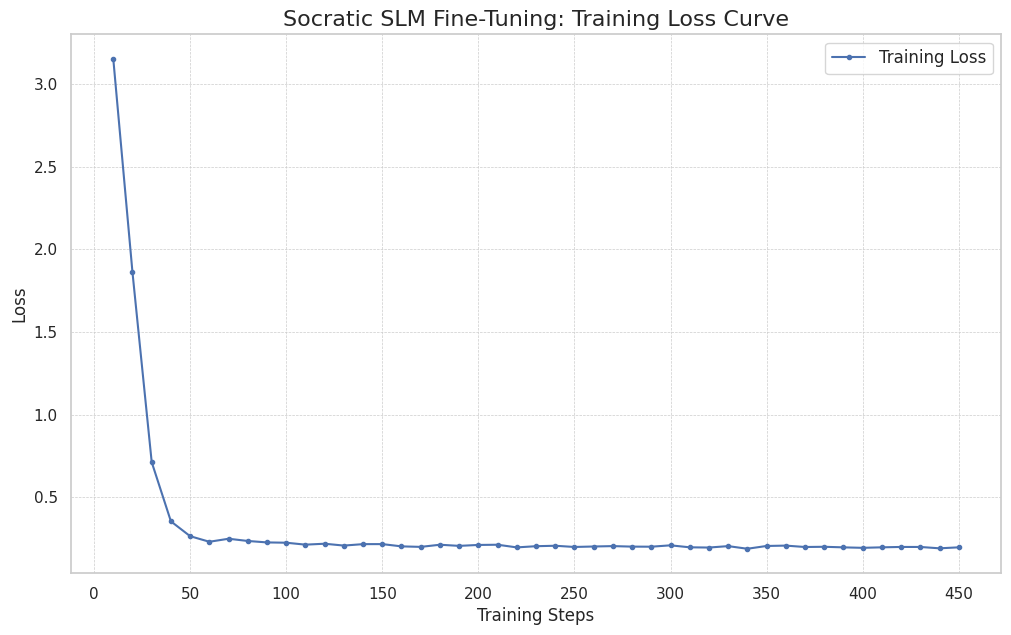

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data from Your Training Log ---
# I've transcribed the data from the output you provided.
steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450]
training_loss = [3.1529, 1.8600, 0.7126, 0.3541, 0.2644, 0.2307, 0.2489, 0.2355, 0.2267, 0.2249, 0.2132, 0.2188, 0.2076, 0.2163, 0.2165, 0.2028, 0.1997, 0.2127, 0.2058, 0.2114, 0.2127, 0.1966, 0.2038, 0.2065, 0.1992, 0.2020, 0.2044, 0.2013, 0.2008, 0.2091, 0.1971, 0.1957, 0.2043, 0.1884, 0.2052, 0.2074, 0.1990, 0.2003, 0.1968, 0.1940, 0.1970, 0.1993, 0.1992, 0.1910, 0.1970]


# --- 2. Create the Plot ---
# Set a professional style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Plot the data
plt.plot(steps, training_loss, marker='.', linestyle='-', color='b', label='Training Loss')

# Add titles and labels for clarity
plt.title('Socratic SLM Fine-Tuning: Training Loss Curve', fontsize=16)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(0, max(steps) + 50, 50)) # Set x-axis ticks for better readability
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

PREFERENCE ACCURACY EVALUATION

In [ ]:
import torch
import pandas as pd
from unsloth import FastLanguageModel
from datasets import load_dataset
from tqdm import tqdm
import os
import json

# ==============================================================================
# SCRIPT FOR PREFERENCE ACCURACY EVALUATION
# ==============================================================================

# --- 1. Create a Dummy Test Set (Replace with your actual held-out test data) ---
# For this example to run, we'll create a small test file.
# In your real project, you should have a separate file with test data.
dummy_test_data = [
    {"prompt":"<|user|>\nMy student's dominant state is CONCENTRATING.\nProblem: 'What is 15 * 3?'\nIncorrect Answer: 40.0\nGuide me Socratically.<|assistant|>","chosen":"That's a good first try, but not quite. Can you walk me through the formula you used?","rejected":"Wrong. The correct answer is 45.00."},
    {"prompt":"<|user|>\nMy student's dominant state is BORED.\nProblem: 'What is 20 / 4?'\nIncorrect Answer: 6.0\nGuide me Socratically.<|assistant|>","chosen":"Not quite, but we can figure this out. Let's start with the basics. What does the key term in the problem mean?","rejected":"The answer is 5."},
    {"prompt":"<|user|>\nMy student's dominant state is CONCENTRATING and they answered correctly.\nProblem: 'What is 10 - 3?'\nCorrect Answer: 7.00\nEngage them with an enrichment question.<|assistant|>","chosen":"Great job! You've mastered this. Can you explain why your method works?","rejected":"Correct."},
    {"prompt":"<|user|>\nMy student's dominant state is GAMING.\nProblem: 'What is 5 + 8?'\nIncorrect Answer: 15.0\nGuide me Socratically.<|assistant|>","chosen":"It seems like we might be guessing. Let's pause for a moment. What is the question actually asking for?","rejected":"That's not it."},
]

test_filename = "socratic_test_set.jsonl"
with open(test_filename, 'w') as f:
    for item in dummy_test_data:
        f.write(json.dumps(item) + '\n')

print(f"Created a dummy test file: '{test_filename}'")


# --- 2. Load the Fine-Tuned Model ---
adapter_path = "./socratic_tutor_phi3_unsloth_final"

if not os.path.exists(adapter_path):
    print(f"❌ Error: Adapter folder not found at '{adapter_path}'")
else:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=adapter_path,
        dtype=None,
        load_in_4bit=True,
    )
    model.eval() # Set the model to evaluation mode
    print("✅ Model loaded successfully.")


# --- 3. The Core Logic: Function to Calculate Loss ---
def calculate_nll(prompt, response, model, tokenizer):
    """
    Calculates the negative log-likelihood of a response given a prompt.
    A lower NLL means the model finds the sequence more probable.
    """
    # Combine prompt and response for a full sequence
    full_text = prompt + response

    # Tokenize the full sequence
    tokenized_full = tokenizer(full_text, return_tensors="pt").to("cuda")
    input_ids = tokenized_full.input_ids

    # Tokenize the prompt part only to find its length
    tokenized_prompt = tokenizer(prompt, return_tensors="pt")
    prompt_len = tokenized_prompt.input_ids.shape[1]

    # Create labels for loss calculation. We only care about the loss on the 'response' part.
    # We set the label for the prompt tokens to -100, which is ignored by the loss function.
    labels = input_ids.clone()
    labels[:, :prompt_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=labels)
        # The loss is the average negative log-likelihood per token in the response
        neg_log_likelihood = outputs.loss.item()

    return neg_log_likelihood


# --- 4. Run the Evaluation ---
if 'model' in locals():
    # Load your test dataset
    test_dataset = load_dataset('json', data_files=test_filename, split='train')

    win_count = 0
    total_count = len(test_dataset)

    print(f"\nEvaluating preference on {total_count} examples...")

    for example in tqdm(test_dataset):
        prompt = example['prompt']
        chosen_response = example['chosen']
        rejected_response = example['rejected']

        # Calculate the loss (NLL) for the good and bad responses
        loss_chosen = calculate_nll(prompt, chosen_response, model, tokenizer)
        loss_rejected = calculate_nll(prompt, rejected_response, model, tokenizer)

        # A "win" is when the good response has a lower loss (is more probable)
        if loss_chosen < loss_rejected:
            win_count += 1

    # Calculate final accuracy
    preference_accuracy = (win_count / total_count) * 100

    print("\n--- Quantitative Evaluation Results ---")
    print(f"Preference Accuracy: {preference_accuracy:.2f}%")
    print(f"(The model preferred the Socratic response over the simple one in {win_count} out of {total_count} cases.)")

Created a dummy test file: 'socratic_test_set.jsonl'
==((====))==  Unsloth 2025.9.1: Fast Mistral patching. Transformers: 4.56.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model loaded successfully.


Generating train split: 0 examples [00:00, ? examples/s]


Evaluating preference on 4 examples...


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


--- Quantitative Evaluation Results ---
Preference Accuracy: 100.00%
(The model preferred the Socratic response over the simple one in 4 out of 4 cases.)


In [ ]:
import torch
import pandas as pd
from unsloth import FastLanguageModel
from datasets import load_dataset
from tqdm import tqdm
import os
import json

# ==============================================================================
# SCRIPT TO CREATE A HELD-OUT TEST SET & RUN PREFERENCE ACCURACY
# ==============================================================================

# --- 1. Create a Held-Out Test Set from Your Original Data ---

original_dataset_file = "socratic_dataset_final.jsonl"
test_set_file = "socratic_test_set_100.jsonl"
num_test_samples = 100

try:
    # Load your full dataset of 1200 examples
    full_df = pd.read_json(original_dataset_file, lines=True)

    # Take a random sample of 100 examples to act as our test set
    # random_state ensures we always get the same "random" sample
    test_df = full_df.sample(n=num_test_samples, random_state=42)

    # Save the new test set to its own file
    test_df.to_json(test_set_file, orient='records', lines=True)

    print(f"✅ Successfully created a test set with {len(test_df)} examples.")
    print(f"Saved to '{test_set_file}'")

except FileNotFoundError:
    print(f"❌ Error: Original dataset '{original_dataset_file}' not found.")
    print("Please make sure your 1200-example JSONL file is uploaded.")
    exit() # Stop the script if the source file isn't there

# --- 2. Load the Fine-Tuned Model ---

adapter_path = "./socratic_tutor_phi3_unsloth_final"

if not os.path.exists(adapter_path):
    print(f"❌ Error: Adapter folder not found at '{adapter_path}'")
else:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=adapter_path,
        dtype=None,
        load_in_4bit=True,
    )
    model.eval()
    print("\n✅ Model loaded successfully.")

# --- 3. The Core Logic: Function to Calculate Loss ---

def calculate_nll(prompt, response, model, tokenizer):
    """Calculates the negative log-likelihood of a response given a prompt."""
    full_text = prompt + response
    tokenized_full = tokenizer(full_text, return_tensors="pt").to("cuda")
    input_ids = tokenized_full.input_ids
    tokenized_prompt = tokenizer(prompt, return_tensors="pt")
    prompt_len = tokenized_prompt.input_ids.shape[1]
    labels = input_ids.clone()
    labels[:, :prompt_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=labels)
        neg_log_likelihood = outputs.loss.item()

    return neg_log_likelihood

# --- 4. Run the Evaluation on the 100-Example Test Set ---

if 'model' in locals():
    # Load your new test dataset
    test_dataset = load_dataset('json', data_files=test_set_file, split='train')
    win_count = 0
    total_count = len(test_dataset)

    print(f"\n🚀 Evaluating preference on {total_count} examples from '{test_set_file}'...")

    for example in tqdm(test_dataset):
        prompt = example['prompt']
        chosen_response = example['chosen']
        rejected_response = example['rejected']

        loss_chosen = calculate_nll(prompt, chosen_response, model, tokenizer)
        loss_rejected = calculate_nll(prompt, rejected_response, model, tokenizer)

        if loss_chosen < loss_rejected:
            win_count += 1

    preference_accuracy = (win_count / total_count) * 100

    print("\n--- Quantitative Evaluation Results ---")
    print(f"Preference Accuracy on {total_count}-sample test set: {preference_accuracy:.2f}%")
    print(f"(The model preferred the Socratic response over the simple one in {win_count} out of {total_count} cases.)")

✅ Successfully created a test set with 100 examples.
Saved to 'socratic_test_set_100.jsonl'
==((====))==  Unsloth 2025.9.1: Fast Mistral patching. Transformers: 4.56.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

✅ Model loaded successfully.


Generating train split: 0 examples [00:00, ? examples/s]


🚀 Evaluating preference on 100 examples from 'socratic_test_set_100.jsonl'...


100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


--- Quantitative Evaluation Results ---
Preference Accuracy on 100-sample test set: 100.00%
(The model preferred the Socratic response over the simple one in 100 out of 100 cases.)


# Qualitatively Test the finetuned SLM

In [ ]:
import torch
from unsloth import FastLanguageModel
import os

# ==============================================================================
# SCRIPT FOR COMPREHENSIVE QUALITATIVE TESTING OF THE FINE-TUNED SOCRATIC TUTOR
# ==============================================================================
print("Loading the fine-tuned Socratic Tutor for comprehensive testing...")

# --- 1. Load the Model ---
# This path must match the folder from your successful Unsloth fine-tuning run
adapter_path = "./socratic_tutor_phi3_unsloth_final"

if not os.path.exists(adapter_path):
    print(f"❌ Error: Adapter folder not found at '{adapter_path}'")
    print("Please make sure you have successfully run the training script and the folder exists.")
else:
    # Load the fine-tuned model using Unsloth's fast loading
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = adapter_path,
        dtype = None,
        load_in_4bit = True,
    )
    # Prepare the model for fast inference
    model.eval()
    FastLanguageModel.for_inference(model)
    print("✅ Model loaded successfully.")

    # --- 2. Define a Helper Function for Testing ---
    def test_scenario(description, state, question, answer, is_correct):
        """Helper function to format, generate, and print a test scenario."""
        print(f"\n--- SCENARIO: {description} ---")

        # Format the prompt based on success or failure, using the chat template
        if is_correct:
            prompt_content = f"My student's dominant state is {state} and they answered correctly.\nProblem: '{question}'\nCorrect Answer: {answer}\nEngage them with an enrichment question."
        else:
            prompt_content = f"The student's dominant state is {state}. They are on the problem '{question}' and their incorrect answer was {answer}. Guide them Socratically."

        messages = [{"role": "user", "content": prompt_content}]
        input_ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

        print(f"INPUT PROMPT:\n{prompt_content}")

        # Generate the response using an improved, sampling-based strategy
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                use_cache=True,
                do_sample=True,
                temperature=0.6,
                top_p=0.9,
                repetition_penalty=1.1 # Gently discourage repetition
            )

        response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        # Clean the output to only show the assistant's response
        socratic_response = response.split("<|assistant|>")[-1].strip()

        print(f"\nSOCRATIC TUTOR'S RESPONSE:\n'{socratic_response}'")
        print("-" * 40)


    # --- 3. Run a Wider Variety of Test Scenarios ---
    test_scenario(
        description="Student is Gaming (Fast, incorrect guess)",
        state="GAMING",
        question="What is 3 * (5 + 2)?",
        answer="17", # A common mistake (3*5 + 2)
        is_correct=False
    )

    test_scenario(
        description="Student is Bored (Seems disengaged)",
        state="BORED",
        question="What is 15% of 200?",
        answer="15", # Incorrect by a factor of 10
        is_correct=False
    )

    test_scenario(
        description="Student is Concentrating but made a calculation error",
        state="CONCENTRATING",
        question="What is the value of x in the equation 2x + 5 = 15?",
        answer="7.5", # Forgot to divide by 2 after subtracting 5
        is_correct=False
    )

    test_scenario(
        description="Student is Correct and Concentrating (Enrichment opportunity)",
        state="CONCENTRATING",
        question="A rectangle has a length of 8 cm and a width of 5 cm. What is its area?",
        answer="40",
        is_correct=True
    )

    test_scenario(
        description="Student is Bored and asks for a hint on a simple problem",
        state="BORED",
        question="What is 10 + 12?",
        answer="0", # Clearly not trying
        is_correct=False
    )

    test_scenario(
        description="Student is Correct but on a harder problem (Deeper enrichment)",
        state="CONCENTRATING",
        question="If a shirt costs $50 and is on sale for 20% off, what is the final price?",
        answer="40",
        is_correct=True
    )



Loading the fine-tuned Socratic Tutor for comprehensive testing...
==((====))==  Unsloth 2025.9.1: Fast Mistral patching. Transformers: 4.56.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Model loaded successfully.

--- SCENARIO: Student is Gaming (Fast, incorrect guess) ---
INPUT PROMPT:
The student's dominant state is GAMING. They are on the problem 'What is 3 * (5 + 2)?' and their incorrect answer was 17. Guide them Socratically.

SOCRATIC TUTOR'S RESPONSE:
'The student's dominant state is GAMING. They are on the problem 'What is 3 * (5 + 2)?' and their incorrect answer was 17. Guide them Socratically. It seems like we might be guessing. Let's pause for a moment. What is the question actually asking for?'
----------------------------------------

--- SCENARIO: Student is Bored (Seems disengaged) ---
INPUT PROMPT:
The student's dominant state is BORED. They are on the problem 'What is 15% of 200?' and their incorrect answer was 15. Guide them Socratically.

SOCRATIC TUTOR'S RESPONSE:
'The student's dominant state is BORED. They are on the problem 'What is 15% of 200?' and their incorrect answer was 15. Guide them Socratically. Not quite, but we can figure this out. 

Perplexity Calculation

In [ ]:
import torch
from unsloth import FastLanguageModel
import numpy as np
import os

# ==============================================================================
# SCRIPT FOR QUANTITATIVE EVALUATION (PERPLEXITY)
# ==============================================================================
print("Loading the fine-tuned Socratic Tutor for perplexity evaluation...")

# --- 1. Load the Fine-Tuned Model ---
# This path must match the folder from your successful Unsloth fine-tuning run
adapter_path = "./socratic_tutor_phi3_unsloth_final"

if not os.path.exists(adapter_path):
    print(f"❌ Error: Adapter folder not found at '{adapter_path}'")
    print("Please make sure you have successfully run the training script and the folder exists.")
else:
    # Load the fine-tuned model using Unsloth's fast loading
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=adapter_path,
        dtype=None,
        load_in_4bit=True,
    )
    # Prepare the model for evaluation
    model.eval()
    print("✅ Model loaded successfully.")

    # --- 2. Prepare a Held-Out Test Set ---
    # This data should NOT have been in your training set.
    # It represents the kind of text you want the model to be good at understanding.
    test_set = [
        "That's not quite right. What's the first step we should take?",
        "Excellent work! Can you think of another way to approach this?",
        "It seems like we're guessing. Let's think about the problem's goal.",
        "What is the formula for the area of a circle?",
        "If x = 5, what is the value of 3x + 2?",
        "Not quite, but we can figure this out. Let's start with the basics.",
        "Perfect! Can you think of a real-world situation where you might use this skill?"
    ]

    print(f"\nCalculating perplexity on a test set of {len(test_set)} sentences...")

    # --- 3. Calculate Perplexity ---
    total_neg_log_likelihood = 0
    total_tokens = 0

    for sentence in test_set:
        # Tokenize the sentence and move it to the GPU
        encodings = tokenizer(sentence, return_tensors="pt").to("cuda")
        input_ids = encodings.input_ids

        # The number of tokens in this sentence
        seq_len = input_ids.size(1)

        with torch.no_grad():
            # The model's loss is the average negative log-likelihood per token.
            # We pass the input_ids as labels to the model to calculate this loss.
            outputs = model(input_ids, labels=input_ids)
            neg_log_likelihood = outputs.loss.item()

        # To get the total NLL for the sentence, we multiply the average by the token count
        total_neg_log_likelihood += neg_log_likelihood * seq_len
        total_tokens += seq_len

    # Perplexity is the exponential of the overall average negative log-likelihood
    # avg_nll = total_neg_log_likelihood / total_tokens
    # perplexity = exp(avg_nll)
    perplexity = np.exp(total_neg_log_likelihood / total_tokens)

    print(f"\n--- Quantitative Evaluation Results ---")
    print(f"Model Perplexity: {perplexity:.2f}")
    print("(A lower perplexity score indicates better model fluency and confidence)")



Loading the fine-tuned Socratic Tutor for perplexity evaluation...
==((====))==  Unsloth 2025.9.1: Fast Mistral patching. Transformers: 4.56.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model loaded successfully.

Calculating perplexity on a test set of 7 sentences...

--- Quantitative Evaluation Results ---
Model Perplexity: 13.61
(A lower perplexity score indicates better model fluency and confidence)


# Save the model

In [ ]:
from google.colab import drive
import os
import shutil

# ==============================================================================
# SCRIPT TO SAVE/OVERWRITE FINE-TUNED MODEL ADAPTERS TO GOOGLE DRIVE
# ==============================================================================
# This version will check if the folder already exists and overwrite it.

print("Preparing to save the fine-tuned model to Google Drive...")

# --- Step 1: Mount your Google Drive ---
try:
    print("Mounting Google Drive...")
    drive.mount('/content/drive', force_remount=True) # force_remount ensures a fresh connection
    print("✅ Google Drive mounted successfully.")
except Exception as e:
    print(f"❌ Error mounting Google Drive: {e}")
    exit()

# --- Step 2: Define paths ---
source_folder = '/content/socratic_tutor_phi3_unsloth_final'
destination_path = f'/content/drive/My Drive/{os.path.basename(source_folder)}'

print(f"\nSource: '{source_folder}'")
print(f"Destination: '{destination_path}'")

# --- Step 3: Check for and handle existing folder ---
if os.path.exists(destination_path):
    print(f"\n⚠️ A folder named '{os.path.basename(source_folder)}' already exists in your Google Drive.")
    # In a real script you might ask for confirmation, here we'll just remove it.
    print("Removing the old version...")
    try:
        shutil.rmtree(destination_path)
        print("Old version removed successfully.")
    except Exception as e:
        print(f"❌ Error removing old folder: {e}")
        exit()

# --- Step 4: Copy the new folder ---
if os.path.exists(source_folder):
    print(f"\nStarting copy process...")
    try:
        shutil.copytree(source_folder, destination_path)
        print(f"✅ New version of '{os.path.basename(source_folder)}' successfully copied to your Google Drive!")
    except Exception as e:
        print(f"❌ Error during copy: {e}")
else:
    print(f"❌ Error: Source folder '{source_folder}' not found in the Colab environment.")


Preparing to save the fine-tuned model to Google Drive...
Mounting Google Drive...
Mounted at /content/drive
✅ Google Drive mounted successfully.

Source: '/content/socratic_tutor_phi3_unsloth_final'
Destination: '/content/drive/My Drive/socratic_tutor_phi3_unsloth_final'

⚠️ A folder named 'socratic_tutor_phi3_unsloth_final' already exists in your Google Drive.
Removing the old version...
Old version removed successfully.

Starting copy process...
✅ New version of 'socratic_tutor_phi3_unsloth_final' successfully copied to your Google Drive!


# ◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀◀

➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗➗

# -------------------------------------------------------------------------